<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Linear Regression

_Authors:_ Tim Book, Jeff Hale

### Learning Objectives 
- Describe modeling.
- Calculate mean squared error.
- State the assumptions of a linear regression model.
- Be able to interpret the coefficients of a linear regression model.
- Identify the difference between simple and multiple linear regression.
- Fit, generate predictions from, and evaluate a linear regression model in `sklearn`, and maybe in `statsmodels`.

In [2]:
# Imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# New libraries
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Part I: Simple Linear Regression

When you have 1 predictor variable you are doing _simple linear regression_. 

## The Data
Data source: [here](https://www.rdocumentation.org/packages/fpp2/versions/2.3/topics/elecdemand)

The data consist of electricity demand for Victoria, Australia every half-hour in 2014. We have three columns:

* Total electricity demand (in gigawatts)
* Whether or not it is a workday (0/1)
* Temperature (Celcius)

In [3]:
elec = pd.read_csv("./data/elecdemand.csv")

# We'll limit our focus to only days in which it was
# at least 15 degrees Celcius (59 F)
elec = elec[elec["temp"] > 15]

# view it
elec.head()

,demand,workday,temp
0,3.914647,0,18.2
1,3.672550,0,17.9
2,3.497539,0,17.6
3,3.339145,0,16.8
4,3.204313,0,16.3


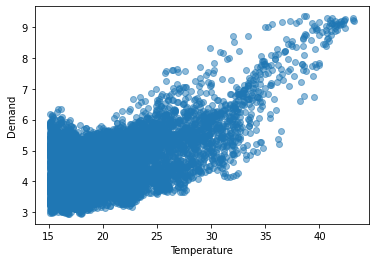

In [8]:
# Plot temperature vs. demand
plt.scatter(elec['temp'], elec['demand'], alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.show()

## The Null model

<details><summary>If we had to guess the demand for any new temperature what would you pick?</summary>
We don't have much information yet, so probably just the mean demand!
</details>

In [10]:
elec_avg = elec['demand'].mean()

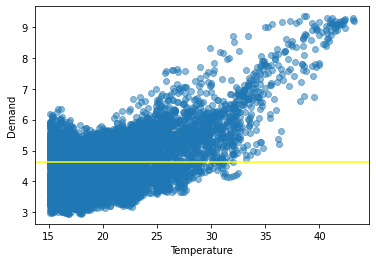

In [12]:
# Plot temperature vs. demand
plt.scatter(elec['temp'], elec['demand'], alpha=0.5)
plt.axhline(elec_avg, color="yellow")
plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.show()

## How could we improve our model?

<details><summary>If we were to draw a straight line that fit the points the best, what would that look like?</summary>
<img src="./images/ols.png", style="height: 350px">
</details>

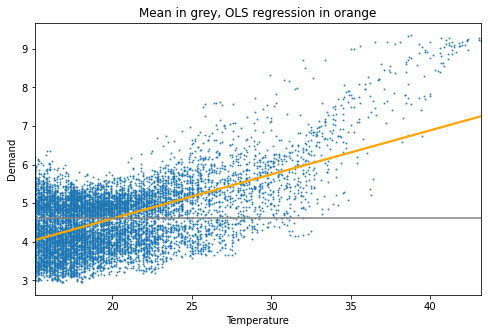

In [16]:
plt.figure(figsize = (8, 5))
sns.regplot(x='temp', y='demand', data=elec, ci=None, 
            scatter_kws = {'s': 1}, 
            line_kws = {'color': 'orange'})
plt.axhline(elec['demand'].mean(), color = 'grey')
plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.title('Mean in grey, OLS regression in orange')
plt.show()

**Is that line better fit to the data than our old line that was just the mean?**

Looks like it. We'll discuss formal evaluation metrics in a bit.

## Lines

This was the equation I learned for a line. Look familiar?
$$ \huge y = mx + b$$
In data science it gets changed to 

$$ \huge  y = \beta_0 + \beta_1 x_1 $$

### Errors

Our model isn't going to be perfect. The things our model doesn't capture are errors and denoted by $\epsilon$ (epsilon).

$$ \huge y = \beta_0 + \beta_1 x_1 + \epsilon $$

### OLS Regression Modeling

We have _x_ and we have _y_. That's our data. 

Our model is trying to figure out the best betas. 

$$ \huge y = \hat \beta_0 + \hat \beta_1 x_1 $$


$\hat \beta_0$ is the y-intercept that our model learns. The point where the line crosses the y-axis.

$\hat \beta_1$ is the coefficient that we multiply by our $x_1$ variable. It's the slope. For every 1 unit it change in $x_1$, y increases by the value of $\beta1$.

$y$ is the ground truth of our target variable. 


$$ \huge \hat y =  \beta_0 +  \beta_1 x_1 $$

When we have a model that has been fit with the data the betas have been computed. We can plug in a new x value and solve for $\hat y$. 

#### $\hat y$ is a prediction! 🎉

---
## OLS regression model in scikit-learn.

### Step 1: Assemble our predictor variables (X) and our target (y) 

 We need an X matrix that is n-by-p.
- n = rows
- p = features

A feature just means a predictor column.

In the simple linear regression case, p = 1. We have one feature ($x_1$). Usually you'll have more than 1 feature. 

In [47]:
# Step 1: Assemble our X and y variables

# We need an X matrix that is n-by-p (in this case, p = 1)
X = elec[['temp']]

In [48]:
X.head()

,temp
0,18.2
1,17.9
2,17.6
3,16.8
4,16.3


#### Why did we make X a DataFrame?
Scikit-learn expects a two dimensional object. Usually we have more than one predictor variable.

y is the outcome variable

In [49]:
# We need a y vector that is length n
y = elec[['demand']]

In [50]:
print(y.shape, type(y))

(9807, 1) <class 'pandas.core.frame.DataFrame'>


#### Why is the target a Series or 1D numpy array? 

Scikit-learn supervised learning estimators are expecting a single output column. They predict one value for each observation, generally.

### Step 2: Instantiate the model

In [51]:
# Step 2: Instantiate the model
lr = LinearRegression()

### Step 3: Fit the model

In [52]:
# Step 3: Fit the model
lr.fit(X, y) # x is always first

LinearRegression()

### Step 4: Check out and interpret our model weights

In [37]:
# Take a peek at the model coefficient and intercept
print(lr.intercept_)
print(lr.coef_)

[2.31876298]
[[0.11415682]]


We now have the following model of reality:

$$\hat{d} = 2.32 + 0.11t$$

#### Interpretation of coefficients

In general, we can interpret our slope as having the following impact:
> For every 1 unit increase in $x_i$, we expect $y$ to increase by $\beta_i$.

<details><summary>How would we interpret the slope for our model?</summary>
For every 1 degree increase in temperature, we would expect 0.11 more gigawatts of electricty to be demanded. 
</details>

#### Interpretation of our y-intercept. Does it make sense?

When it is zero degrees Celsius, we expect 2.32 gigawatts of electricity to be demanded. Ordinarily, this _would_ make sense, however, we have no data near this value and would want to avoid **extrapolation**.

### Step 5: Make predictions

If we had new data points for temperature we could pass it to the predict method to generate price predictions.

We don't have any new data, so let's just see what predictions our model would have made. This is the same as saying "Find the x value for a prediction on the plot and go up to our line. That value for y is our prediction."

We do this for all the x values.

In [38]:
# Make predictions
y_pred = lr.predict(X)

In [39]:
print(y_pred.shape)
y_pred

(9807, 1)


array([[4.39641712],
       [4.36217008],
       [4.32792303],
       ...,
       [4.27084462],
       [4.22518189],
       [4.21376621]])

#### Why don't we pass `y`?

We are predicting y.

In [ ]:
# We can plot them, too!
y_pred

---

To the slides!

---

### Step 6: Evaluation

We now want to see how good a job our model does at predicting demand. **Mean squared error** is a popular scoring metric. 

Lower is better. That's the case whenever "error" is in the metric name.

$$ MSE = \frac{1}{n} \sum (y_i - \hat{y}_i)^2 = \frac{1}{n} \sum e_i^2 $$

#### MSE by hand:

In [53]:
# Create residuals (aka errors): (y - y_hat)
resids = y - y_pred

In [55]:
# Compute the MSE
mse = np.mean(resids**2)
mse # The lower the error, the better your model is

demand    0.505032
dtype: float64

#### How does that model compare to our null model?

In [56]:
# Create the predictions for the "null model"
y_bar = np.mean(y)
y_bar

demand    4.624525
dtype: float64

In [57]:
y - y_bar

,demand
0,-0.709878
1,-0.951975
2,-1.126986
3,-1.285380
4,-1.420212
...,...
17515,-0.899689
17516,-0.862638
17517,-0.815110
17518,-0.488579


In [58]:
# The null MSE
mse_null = np.mean((y - y_bar)**2)

<details><summary>Which model fits the data better?</summary>
The OLS model has lower error.
</details>

Another popular regression metric is the $R^2$, which is defined as:

$$R^2 = 1 - \frac{\text{MSE}}{\text{Null MSE}} = 1 - \frac{\sum (y_i - \hat{y}_i)}{\sum (y_i - \bar{y})}$$

The $R^2$, or **coefficient of determination**, is the proportion of variability in $y$ we can explain with $x$.

In [60]:
# The R2
1 -(mse / mse_null)

demand    0.352265
dtype: float64

#### Interpret $R^2$

35.2% of the variability in electricity demand can be explained by temperature.

We don't have to calculate these metrics by hand. `sklearn` can do it for us!

In [61]:
# MSE
metrics.mean_squared_error(y, y_pred)

0.5050316037069877

In [62]:
# Can compute R2 from metrics...
metrics.r2_score(y, y_pred)

0.3522649449077143

In [63]:
# ... or directly from the model...
lr.score(X, y)

0.3522649449077143

### You made your first Linear Regression Model 🎉

---

To the slides!

---

## LINE Assumptions
Let's check em!

Text(0, 0.5, 'Demand')

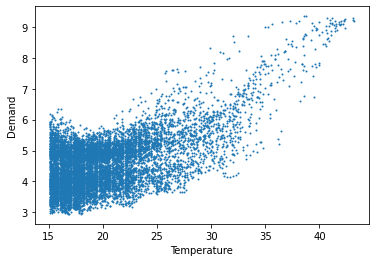

In [65]:
# L - Linearity
plt.scatter(elec["temp"], elec["demand"], s=1)
plt.xlabel('Temperature')
plt.ylabel('Demand')

<details><summary>Does this pass our L assumption?</summary>
It's definitely a little curved, but this looks okay.
</details>

In [ ]:
# I - Independence

<details><summary>Does this pass our I assumption?</summary>
Yes, by assumption.
</details>

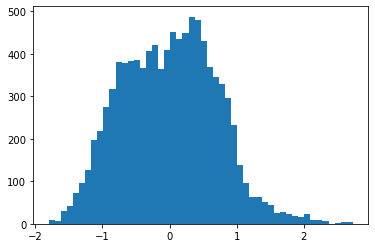

In [66]:
# N - Normality of errors
plt.hist(resids, bins=50);

<details><summary>Does this pass our N assumption?</summary>
Just like with the Linearity assumption, this isn't great, but we might be able to get away with it.
</details>

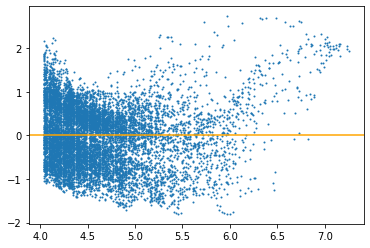

In [67]:
# E - Equal variance of errors
plt.scatter(y_pred, resids, s=1)
plt.axhline(0, color="orange");

<details><summary>Does this pass our E assumption?</summary>
I'm gonna go with no on this one...
</details>

---

To the slides!

---

# Part II: Multiple Linear Regression

When you have more than 1 predictor variable you are doing _multiple linear regression_. 

## Bikeshare Data 🚴‍♂️
Data adapted from source: [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)


Multiple Linear Regression (MLR) with Categorical Features

#### Goal: predict the numer of riders (count), based on the features.

In [80]:
bike = pd.read_csv("./data/bikeshare.csv")
print(bike.shape) # Remember to always do this - It is a good practice
bike.info()

(10886, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### Some preprocessing to clean things up:
1. Rename "count" to "riders"
2. Drop "casual" and "registered"
3. Cast "datetime" to actually be a datetime
4. Drop rows where weather is 4

In [81]:
# Some preprocessing:
# 1 - Rename "count" to "riders"
# 2 - Drop "casual" and "registered"
# 3 - Cast "datetime" to actually be a datetime
# 4 - Drop only row where weather == 4

bike.rename(columns = {'count':'riders'}, inplace=True)
bike.drop(columns = ['casual', 'registered'], inplace=True)
bike['datetime'] = pd.to_datetime(bike['datetime'])
bike = bike.loc(bike['weather']==4, axis=0, inplace=True)

TypeError: __call__() got multiple values for argument 'axis'

### Ridership model
Let's try to predict the number of riders based on temperature and what season it is. We'll have to **one-hot encode** the season column!

### Step 1: Assemble our predictor variables (X) and our target (y) 

In [ ]:
# Dummify "season"
X = bike[['season', 'temp']]
X = pd.get_dummies(data=X, columns=['season'], drop_first=True)

### Step 2: Instantiate the model

### Step 3: Fit the model

In [ ]:
# Fit model


### Step 4: Check out and interpret our coefficients

In [ ]:
# Coefficients


#### Interpretation of coefficients
Now that we have multiple variables, our interpretation are **holding all other variables constant**. 
> For every 1 unit increase in $x_i$, we expect $y$ to increase by $\beta_i$, holding all else constant.

Furthermore, each interpretation of a dummy variable is **in relation to the baseline** (in this case, Winter).

**Interpretation of $\hat{\beta}_3$ (`season_3` - Summer):**
Holding the temperature constant, the effect of it being Summer contributes to 105 fewer riders per hour relative to Winter.

<details><summary>Interpret the coefficient for temp.</summary>
Holding all else constant, for every one-degree increase in temperature, we expect about 14 more riders per hour.
</details>

<details><summary>Interpret the coefficient for season_4 (Fall).</summary>
Holding the temperature constant, the effect of it being Fall contributes to 26 more riders per hour relative to Winter.
</details>

### Step 5: Make predictions

### Step 6: Evaluate the model

In [ ]:
# R2:


In [ ]:
# MSE:


<details><summary>How is our model?</summary>
Overall, this model isn't great. Only about 20% of the variation in ridership can be explained by the model.
</details>

So our model is pretty bad. How much should we trust our interpretation for the coefficients?
> Do our LINE assumptions hold?

When working with multiple linear regression, we add a secret 5th "assumption" to our LINE assumptions that is usually violated at least a little.

### LINEM
- L - Linear relationship
- I - Independent errors
- N - Normally distributed errors
- E - Equal variance of errors (homoscedasticity)
- M - No Multicollinearity/Independence of Predictors

In [ ]:
# L:


In [ ]:
# I:


In [ ]:
# N:


In [ ]:
# E:


In [ ]:
# M/I:


Yikes! We should probably not say anything very strong about the coefficients in our interpretation. 

## NOW YOU

Let's make a better model.

Now your turn: Fit a model that uses _all_ x-variables (excluding `atemp`) as well as the **the hour of day**. One-hot encode columns accordingly.

In [ ]:
bike.head()

In [ ]:
bike["hour"] = bike["datetime"].dt.hour

# Additional, not-really-BONUS topics

## ANRBT #1: Multicollinearity
Multicollinearity occurs when you have two or more $x$-variables that are correlated with eachother. This phenomenon doesn't affect the quality of the model fit, but it completely destroys model inference (ie, confidence intervals and hypothesis tests, more on this next week). In addition, it can also contribution to a **rank-deficient matrix**, meaning the model can't be fit at all!

In [ ]:
np.corrcoef(bike.temp, bike.atemp)

In [ ]:
bike[['temp', 'atemp']].corr()

## ANRBT #2: The Curse of Dimensionality
It turns out that the more variables we add to our model, the better it is. Actually, it doesn't even matter what this variable was, that will always be true. Even if it's completely irrelevant. That is, if we added the following variables to our model:

* Is there a sunspot on this day?
* The closing stock price of Apple that day.
* Whether or not Guy Fieri had pancakes for breakfast that day.
* A column of completely random standard normal variables

Our model is **guaranteed** to get better. But it isn't _really_ a better model, right? It turns out, we're modeling **noise**, not **signal**. We'll talk more about this phenomenon later.

## ANRBT #3: Matrix Notation and Solution
Recall our matrix notations:

$$
\mathbf{y} = \begin{bmatrix} y_1 & y_2 & \cdots & y_n \end{bmatrix}^T
$$

$$
\beta = \begin{bmatrix} \beta_0 & \beta_1 & \cdots & \beta_p \end{bmatrix}^T
$$

$$
\mathbf{X} = \begin{bmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1p} \\
1 & x_{21} & x_{22} & \cdots & x_{2p} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
1 & x_{n1} & x_{n2} & \cdots & x_{np} \\ 
\end{bmatrix}
$$

It then works out we can write our model as:

$$\mathbf{y} = \mathbf{X}\beta + \varepsilon$$

Which makes our solution:

$$\mathbf{\hat{y}} = \mathbf{X}\hat{\beta}$$

where

$$\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

Look confusing? It is! It haunts the dreams of second-year grad students. But it's not _too_ mysterious. If you'd like to understand it better, check out the **numpy ladder challenge**. Really, the take away here is singular:

### **The solution to our problem exists in closed form and can be computed by simple matrix multiplication.**

## ANRBT #4: The `statsmodels` Library
Scikit-Learn does not hold the monopoly in doing linear regression in Python. In fact, you may even like this better!

In [ ]:
import statsmodels.api as sm

X = elec[["temp", "workday"]]
X = sm.add_constant(X)
y = elec["demand"]
ols = sm.OLS(y, X).fit()

In [ ]:
ols.summary()

# Conclusions and Takeaways:
* Machine learning, aka statistical modeling, is an important and vast topic we'll spend much of our course exploring. It comes in many varieties for different situations.
* Linear regression is a **supervised "white-box" regression model**.
* As far as machine learning goes, OLS is very simple, yet still powerful.
* One of its more enticing feature is that its **coefficients are interpretable!**
* In the midst of all this, we learned how to handle dummy variables, something important for all of the models we'll learn about.